In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

data_path = "SportsImageClassification"
batch_size = 32
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Transformations ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  
])

train_data = datasets.ImageFolder(f"{data_path}/train", transform=transform)
valid_data = datasets.ImageFolder(f"{data_path}/valid", transform=transform)
test_data  = datasets.ImageFolder(f"{data_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"[{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {correct/total:.2%}")


c:\Users\dumas\PycharmProjects\DeepLearning\.envdeep\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dumas\PycharmProjects\DeepLearning\.envdeep\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/5] Loss: 1.8561
[2/5] Loss: 0.4237
[3/5] Loss: 0.1239
[4/5] Loss: 0.0415
[5/5] Loss: 0.0187
✅ Test Accuracy: 97.80%


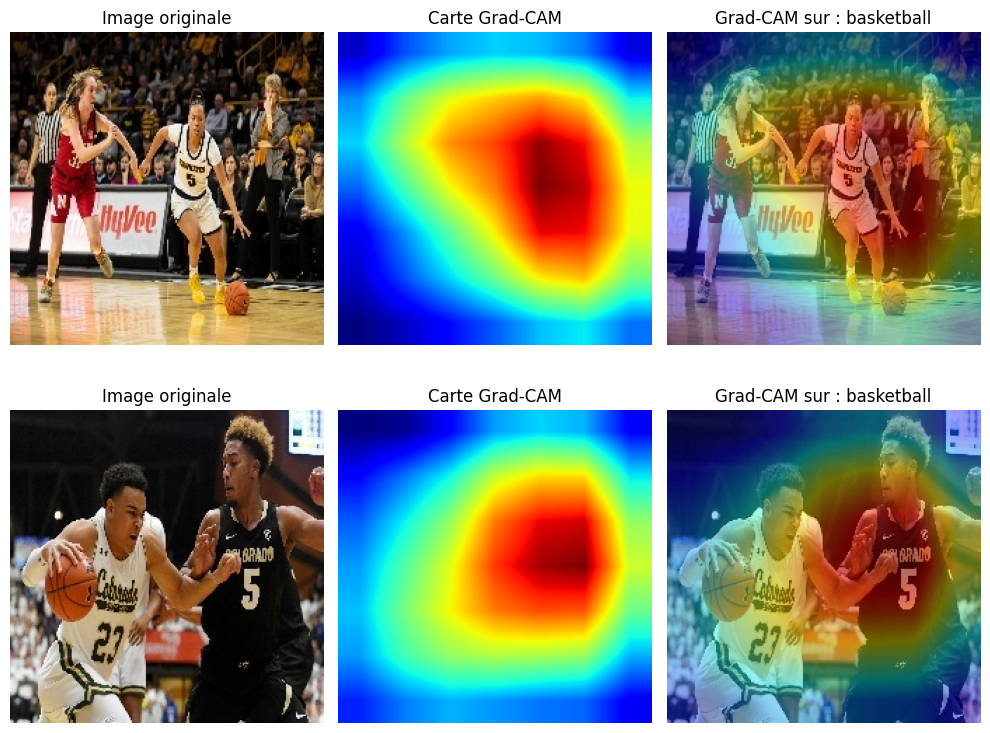

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_gradcam(image, model, class_names):
    input_tensor = image.unsqueeze(0).to(device)
    model.eval()
    activations.clear()
    gradients.clear()

    output = model(input_tensor)
    pred_class = output.argmax().item()

    model.zero_grad()
    output[0, pred_class].backward()

    grad = gradients[0]
    act = activations[0]
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * act).sum(dim=1).squeeze()
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))

    img_np = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
    img_np = np.clip(img_np, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    superimposed = np.clip(0.6 * img_np + 0.4 * heatmap, 0, 1)

    return img_np, cam, superimposed, class_names[pred_class]

activations = []
gradients = []

target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(lambda m, i, o: activations.append(o))
target_layer.register_full_backward_hook(lambda m, gi, go: gradients.append(go[0]))

images_to_plot = [41, 44]  

fig, axs = plt.subplots(len(images_to_plot), 3, figsize=(10, 4 * len(images_to_plot)))

for idx, image_idx in enumerate(images_to_plot):
    image, label = test_data[image_idx]
    original, cam_map, fusion, predicted_class = generate_gradcam(image, model, train_data.classes)

    axs[idx, 0].imshow(original)
    axs[idx, 0].set_title("Image originale")
    axs[idx, 1].imshow(cam_map, cmap="jet")
    axs[idx, 1].set_title("Carte Grad-CAM")
    axs[idx, 2].imshow(fusion)
    axs[idx, 2].set_title(f"Grad-CAM sur : {predicted_class}")

    for ax in axs[idx]:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [14]:
import pickle

torch.save(model.state_dict(), "resnet_model.pth")

with open("class_names.pkl", "wb") as f:
    pickle.dump(train_data.classes, f)

print("✅ Modèle et classes sauvegardés pour Streamlit.")


✅ Modèle et classes sauvegardés pour Streamlit.


In [5]:
from collections import Counter

print("Répartition train :", Counter([label for _, label in train_data]))
print("Répartition test  :", Counter([label for _, label in test_data]))


Répartition train : Counter({31: 191, 32: 190, 58: 189, 7: 174, 41: 172, 8: 169, 59: 167, 71: 166, 18: 164, 68: 163, 69: 159, 40: 158, 26: 157, 29: 157, 36: 157, 64: 157, 66: 157, 85: 157, 92: 156, 28: 151, 53: 151, 35: 150, 52: 150, 16: 149, 73: 149, 78: 148, 5: 147, 39: 147, 80: 147, 11: 145, 72: 144, 70: 143, 84: 142, 93: 142, 23: 141, 67: 141, 86: 141, 12: 140, 43: 139, 13: 138, 63: 138, 45: 136, 50: 136, 81: 136, 25: 135, 88: 135, 22: 134, 30: 134, 42: 134, 96: 134, 75: 133, 83: 133, 2: 132, 49: 132, 56: 132, 19: 131, 33: 131, 60: 131, 87: 131, 47: 130, 74: 130, 76: 130, 95: 130, 21: 129, 27: 128, 54: 128, 90: 128, 55: 127, 17: 125, 89: 125, 6: 123, 24: 123, 37: 122, 82: 122, 38: 121, 14: 120, 20: 120, 65: 120, 98: 119, 34: 118, 51: 118, 61: 118, 79: 117, 15: 116, 4: 113, 0: 112, 1: 112, 48: 112, 62: 112, 57: 111, 10: 110, 9: 108, 46: 108, 97: 106, 94: 103, 44: 102, 3: 99, 99: 98, 91: 97, 77: 59})
Répartition test  : Counter({0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9

In [6]:
correct_val = total_val = 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct_val += (preds == labels).sum().item()
        total_val += labels.size(0)

print(f"📊 Validation Accuracy: {correct_val / total_val:.2%}")


📊 Validation Accuracy: 96.80%


📊 Répartition des classes (train)


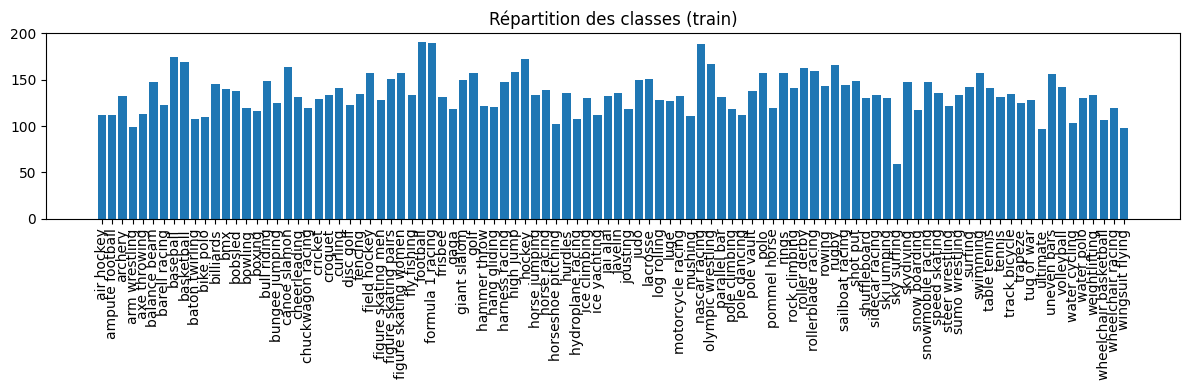

📊 Nombre total d'images : 13492
🏅 Top 3 des classes les plus représentées :
   - football : 191 images
   - formula 1 racing : 190 images
   - nascar racing : 189 images
🧊 Top 3 des classes les moins représentées :
   - sky surfing : 59 images
   - ultimate : 97 images
   - wingsuit flying : 98 images


In [13]:
train_data = datasets.ImageFolder(f"{data_path}/train", transform=transform)
valid_data = datasets.ImageFolder(f"{data_path}/valid", transform=transform)
test_data  = datasets.ImageFolder(f"{data_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)

def plot_class_distribution(data, title):
    labels = [label for _, label in data]
    counter = Counter(labels)
    classes = data.classes
    dist = {classes[i]: counter[i] for i in counter}
    
    plt.figure(figsize=(12, 4))
    plt.bar(dist.keys(), dist.values())
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    total = sum(dist.values())
    top3 = sorted(dist.items(), key=lambda x: x[1], reverse=True)[:3]
    bottom3 = sorted(dist.items(), key=lambda x: x[1])[:3]

    print(f"📊 Nombre total d'images : {total}")
    print("🏅 Top 3 des classes les plus représentées :")
    for cls, count in top3:
        print(f"   - {cls} : {count} images")
    print("🧊 Top 3 des classes les moins représentées :")
    for cls, count in bottom3:
        print(f"   - {cls} : {count} images")

        
print("📊 Répartition des classes (train)")
plot_class_distribution(train_data, "Répartition des classes (train)")


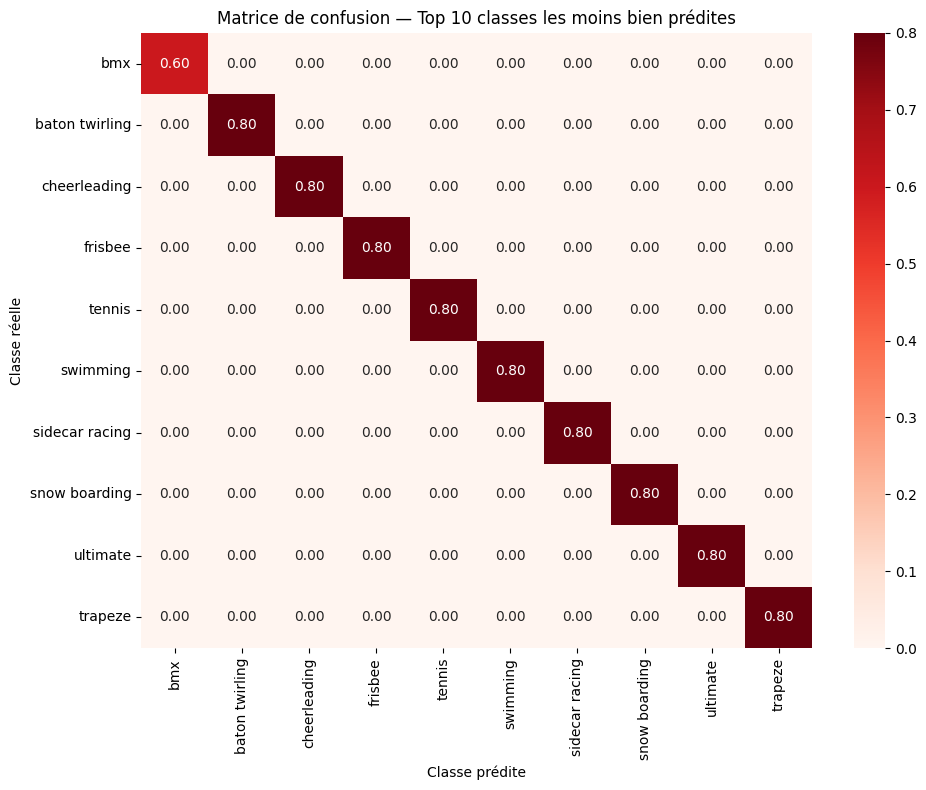

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Matrice brute
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(test_data.classes))))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Accuracy par classe (diagonale)
accuracies = np.diag(cm_normalized)
worst_indices = np.argsort(accuracies)[:10]  # Top 10 pires classes

# Extraire sous-matrice
cm_worst = cm_normalized[np.ix_(worst_indices, worst_indices)]
labels_worst = [test_data.classes[i] for i in worst_indices]

# Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(cm_worst, annot=True, fmt=".2f", xticklabels=labels_worst, yticklabels=labels_worst, cmap="Reds")
plt.title("Matrice de confusion — Top 10 classes les moins bien prédites")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.tight_layout()
plt.show()


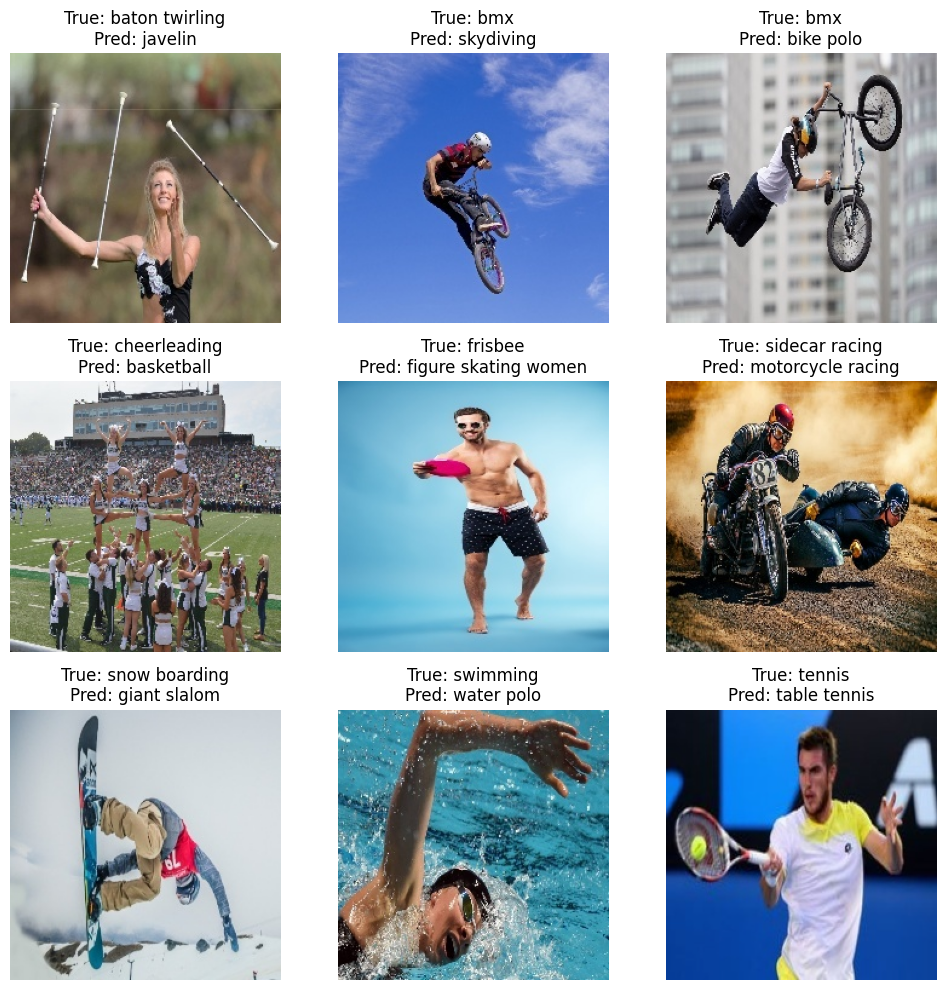

In [9]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
errors = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for img, label, pred in zip(images, labels, preds):
            if label != pred:
                errors.append((img.cpu(), label.item(), pred.item()))

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for ax, (img, label, pred) in zip(axs.flat, errors[:9]):
    ax.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  
    ax.set_title(f"True: {test_data.classes[label]}\nPred: {test_data.classes[pred]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

y_true = np.array(y_true)
y_pred = np.array(y_pred)
per_class_accuracy = {}

for i, class_name in enumerate(test_data.classes):
    mask = y_true == i
    correct = (y_pred[mask] == i).sum()
    total = mask.sum()
    acc = correct / total if total > 0 else 0
    per_class_accuracy[class_name] = acc

sorted_acc = sorted(per_class_accuracy.items(), key=lambda x: x[1])
for cls, acc in sorted_acc[:10]:
    print(f"{cls:25s} : {acc:.2%}")


bmx                       : 60.00%
baton twirling            : 80.00%
cheerleading              : 80.00%
frisbee                   : 80.00%
sidecar racing            : 80.00%
snow boarding             : 80.00%
swimming                  : 80.00%
tennis                    : 80.00%
trapeze                   : 80.00%
ultimate                  : 80.00%
